# 实现目标
1. 支持指定日期的未来收盘价预测  
用户可指定任意日期，模型自动预测该日期之后若干天（如6天）的收盘价。
2. 输出预测结果  
逐日输出未来收盘价预测结果，便于用户查看具体数值。
3. 可视化预测收盘价变化曲线  
自动绘制未来收盘价预测变化曲线，直观展示股票走势趋势。
便于实际数据对比分析

# 1. 导入相关的库

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
import pandas as pd
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
import torch
import joblib
import numpy as np
import matplotlib.pyplot as plt

# 2. 预测函数

In [28]:
def tft_stock_predict(
    filepath,
    predict_start_date,
    model_ckpt_path,
    max_encoder_length: int = 24,
    max_prediction_length: int = 6,
    normalizer_path: str = "target_normalizer.pkl",
    encoding: str = 'utf-8'
):
    """
    修正版：返回两个日期完全对齐的DataFrame（仅含预测期间的数据）
    Returns:
        actual_df: 预测日期对应的真实值（仅含 date, actual_close）
        pred_df: 预测值（仅含 date, pred_close）
    """
    try:
        df_full = pd.read_csv(filepath, encoding=encoding)
        df_full["date"] = pd.to_datetime(df_full["date"])
        df_full["time_idx"] = df_full["date"].rank(method="dense").astype(int) - 1
        
        # 特征工程（预测必需）
        df_full["month"] = df_full["date"].dt.month.astype(str)
        df_full["dayofweek"] = df_full["date"].dt.dayofweek.astype(str)
        df_full["adjustflag"] = df_full["adjustflag"].astype(str)
        df_full["log_volume"] = np.log1p(df_full["volume"])
        df_full["high_low_ratio"] = (df_full["high"] - df_full["low"]) / df_full["close"]
        df_full["amount_per_share"] = df_full["amount"] / df_full["volume"]
        df_full["price_range"] = df_full["high"] - df_full["low"]
        df_full["isST"] = df_full["isST"].astype(str)
        
        # 数据过滤和缺失值填充
        df_full = df_full[df_full["tradestatus"] == 1].copy()
        df_full.fillna({
            "volume": 0,
            "amount": 0,
            "turn": 0,
            "pctChg": 0
        }, inplace=True)
        
        # 验证预测起始日期
        predict_start_date = pd.to_datetime(predict_start_date)
        if predict_start_date not in df_full["date"].values:
            raise ValueError(f"预测起始日期 {predict_start_date.strftime('%Y-%m-%d')} 不在数据集中")
        
        predict_start_idx = df_full[df_full["date"] == predict_start_date]["time_idx"].values[0]
        required_min_idx = predict_start_idx - max_encoder_length
        
        if required_min_idx < 0:
            raise ValueError(
                f"历史数据不足！需要至少 {max_encoder_length} 天历史数据，"
                f"但当前起始日期仅能追溯到 {df_full[df_full['time_idx']==0]['date'].values[0]}"
            )
        
        # 加载归一化器和模型
        if not joblib.os.path.exists(normalizer_path):
            raise FileNotFoundError(f"归一化器文件未找到：{normalizer_path}")
        target_normalizer = joblib.load(normalizer_path)
        
        prediction_data = df_full[df_full["time_idx"] >= required_min_idx].copy()
        prediction_dataset = TimeSeriesDataSet(
            prediction_data,
            time_idx="time_idx",
            target="close",
            group_ids=["code"],
            min_encoder_length=max_encoder_length // 2,
            max_encoder_length=max_encoder_length,
            min_prediction_length=1,
            max_prediction_length=max_prediction_length,
            static_categoricals=["code", "isST"],
            static_reals=[],
            time_varying_known_categoricals=["month", "dayofweek", "adjustflag"],
            time_varying_known_reals=[
                "time_idx", "preclose", "pctChg", "turn", "amount_per_share", "price_range"
            ],
            time_varying_unknown_categoricals=[],
            time_varying_unknown_reals=[
                "close", "open", "high", "low", "volume", "log_volume", "amount", "high_low_ratio"
            ],
            target_normalizer=target_normalizer,
            add_relative_time_idx=True,
            add_target_scales=True,
            add_encoder_length=True,
            allow_missing_timesteps=True
        )
        
        if not joblib.os.path.exists(model_ckpt_path):
            raise FileNotFoundError(f"模型文件未找到：{model_ckpt_path}")
        best_tft = TemporalFusionTransformer.load_from_checkpoint(model_ckpt_path)
        
        predict_dataloader = prediction_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)
        predictions = best_tft.predict(predict_dataloader, return_x=True)
        

        predict_dates = df_full[df_full["time_idx"] >= predict_start_idx]["date"].head(max_prediction_length).values
        
        # 处理预测值
        pred_close = predictions.output[0][:max_prediction_length]
        if hasattr(pred_close, 'cpu'):
            pred_close = pred_close.cpu().numpy()
        pred_close = np.round(pred_close, 2)
        
        # 预测DataFrame（仅预测期间）
        pred_df = pd.DataFrame({
            "date": pd.to_datetime(predict_dates),
            "pred_close": pred_close
        }).reset_index(drop=True)
        
        actual_close = []
        for date in predict_dates:
            # 按预测日期精准匹配真实收盘价
            real_val = df_full[df_full["date"] == date]["close"].values
            # 有真实值则保留，无则填充NaN
            actual_close.append(np.round(real_val[0], 2) if len(real_val) > 0 else np.nan)
        
        # 真实值DataFrame（仅预测期间，与pred_df日期完全对齐）
        actual_df = pd.DataFrame({
            "date": pd.to_datetime(predict_dates),
            "actual_close": actual_close
        }).reset_index(drop=True)
        
        return actual_df, pred_df
    
    except Exception as e:
        print(f"预测过程出错：{str(e)}")
        return None, None

# 3. 预测未来几天的收盘价 

**对应输入股票数据文件和已训练好的模型文件，进行推理预测**

In [35]:
actual_df, pred_df = tft_stock_predict(
    filepath='../data/day_k_datash.600000.csv',
    predict_start_date="2025-09-16", 
    model_ckpt_path=r".\training_logs\tft_stock_prediction\version_4\checkpoints\epoch=19-step=1000.ckpt"
)
print(result_df)
print(raw_predictions)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


        date  actual_close
0 2025-09-16         13.16
1 2025-09-17         12.96
2 2025-09-18         12.75
3 2025-09-19         12.81
4 2025-09-22         12.54
5 2025-09-23         12.45
        date  pred_close
0 2025-09-16        8.58
1 2025-09-17        8.02
2 2025-09-18        7.47
3 2025-09-19        7.25
4 2025-09-22        6.93
5 2025-09-23        6.63


# 4. 结果展示

In [42]:
def plot_aligned_pred_actual(
    actual_df: pd.DataFrame,
    pred_df: pd.DataFrame,
    figsize: tuple = (10, 6),
    title: str = "股票收盘价 预测值 vs 真实值对比（仅预测期间）",
    save_path: str = None
):
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei', 'Arial Unicode MS']
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['xtick.labelsize'] = 10 
    plt.rcParams['ytick.labelsize'] = 10
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 14

    # 数据验证和预处理
    actual_df["date"] = pd.to_datetime(actual_df["date"])
    pred_df["date"] = pd.to_datetime(pred_df["date"])
    
    # 按日期排序
    actual_df = actual_df.sort_values("date").reset_index(drop=True)
    pred_df = pred_df.sort_values("date").reset_index(drop=True)
    
    # 确保两个DataFrame日期完全一致
    if not actual_df["date"].equals(pred_df["date"]):
        print("两个DataFrame的日期不完全对齐，已自动按日期合并")
        merged_df = pd.merge(pred_df, actual_df, on="date", how="outer")
        actual_df = merged_df[["date", "actual_close"]].copy()
        pred_df = merged_df[["date", "pred_close"]].copy()

    # 创建图表
    fig, ax = plt.subplots(figsize=figsize)

    # 绘制真实值
    mask_actual = pd.notna(actual_df["actual_close"])  # 过滤NaN值
    if mask_actual.any():
        ax.plot(
            actual_df.loc[mask_actual, "date"],
            actual_df.loc[mask_actual, "actual_close"],
            color="#2E86AB",
            linewidth=3,
            marker="s",
            markersize=8,
            label="真实收盘价"
        )
    else:
        print("无可用的真实值数据，仅展示预测值")

    # 绘制预测值（橙色虚线+圆形标记）
    mask_pred = pd.notna(pred_df["pred_close"])  # 过滤NaN值
    if mask_pred.any():
        ax.plot(
            pred_df.loc[mask_pred, "date"],
            pred_df.loc[mask_pred, "pred_close"],
            color="#E63946",
            linewidth=3,
            linestyle="--",
            marker="o",
            markersize=8,
            label="预测收盘价"
        )

    # 图表美化
    ax.set_xlabel("日期", fontweight="bold")
    ax.set_ylabel("收盘价（元）", fontweight="bold")
    ax.set_title(title, fontweight="bold", pad=20)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, linestyle="-", linewidth=0.5)
    ax.legend(loc="best", framealpha=0.9, shadow=True, fontsize=11)

    if mask_actual.any() and mask_pred.any():
        valid_data = pd.merge(
            pred_df[mask_pred],
            actual_df[mask_actual],
            on="date",
            how="inner"
        )
        if not valid_data.empty:
            mae = np.mean(np.abs(valid_data["pred_close"] - valid_data["actual_close"]))
            mape = np.mean(np.abs((valid_data["pred_close"] - valid_data["actual_close"]) / valid_data["actual_close"])) * 100
            
            # 在图表顶部添加误差信息
            error_text = f"MAE: {mae:.2f}元 | MAPE: {mape:.2f}%"
            ax.text(
                0.5, 0.95, error_text, transform=ax.transAxes,
                ha="center", va="top", fontsize=12, fontweight="bold",
                bbox=dict(boxstyle="round,pad=0.5", facecolor="#F8F9FA", alpha=0.9)
            )

    
    plt.show()
    plt.close()

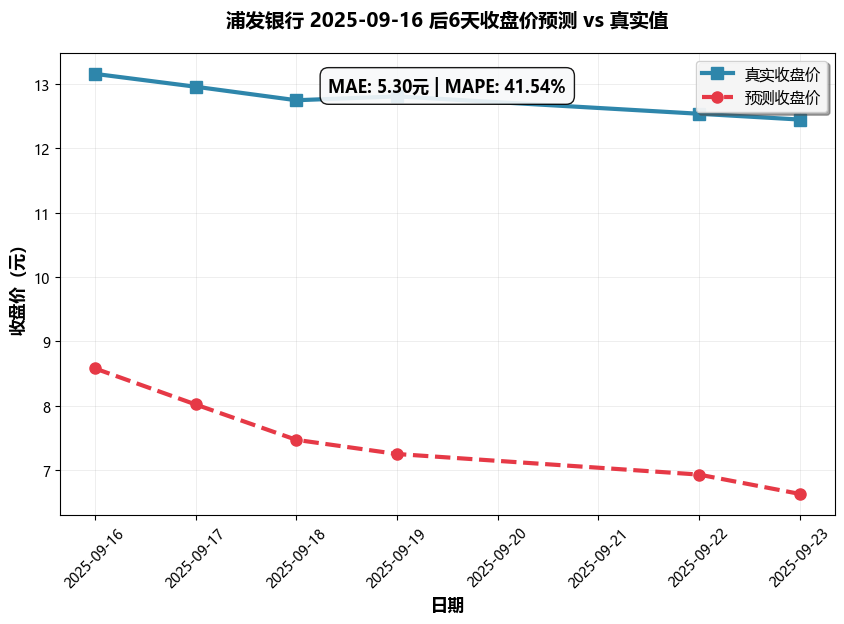

In [43]:
plot_aligned_pred_actual(
        actual_df=actual_df,
        pred_df=pred_df,
        title="浦发银行 2025-09-16 后6天收盘价预测 vs 真实值",
        save_path="./预测对比图/浦发银行_预测期间对比.png"
    )